In [1]:
!python -c "import torch; print(torch.__version__)"

2.2.1+cu121


In [ ]:
!pip uninstall bigframes cudf-cu12 google-colab plotnine statsmodels pymc arviz xarray --y --quiet
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cu121.html --quiet
!pip install torch-geometric==2.4.0 --quiet
!pip install torch-geometric-temporal --quiet

In [3]:
from IPython.display import clear_output

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN, GConvGRU, DCRNN

from sklearn.model_selection import train_test_split

cudnn.benchmark = True
cuda = torch.cuda.is_available()

#Loading Data

In [4]:
df_data = pd.read_csv("/content/combined_ME_EX_v2.csv", index_col=0)
df_locations = pd.read_csv("/content/locations_v2.csv")

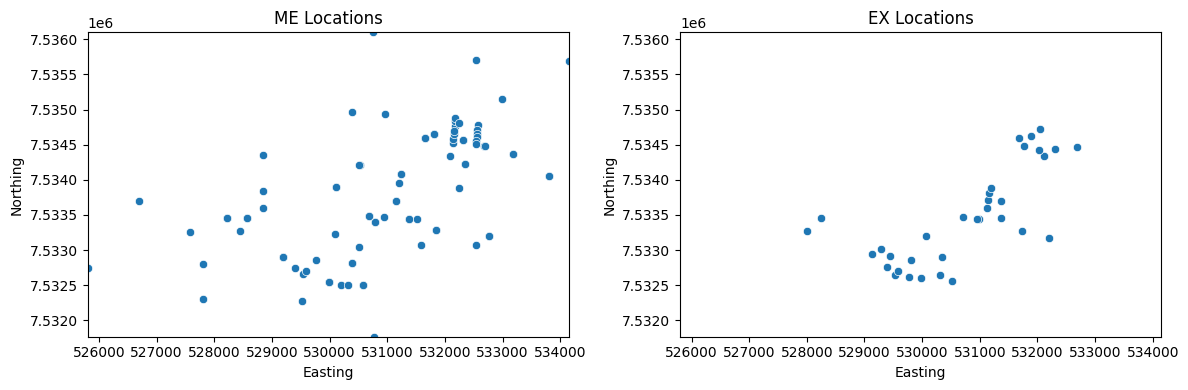

In [5]:
df_me = df_locations.loc[df_locations["ID"].str.contains('ME')]
df_ex = df_locations.loc[df_locations["ID"].str.contains('EX')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(ax=ax1, data=df_me, x='Easting', y='Northing')
ax1.set_title('ME Locations')
ax1.set_xlim((df_locations['Easting'].min(), df_locations['Easting'].max()))
ax1.set_ylim((df_locations['Northing'].min(), df_locations['Northing'].max()))

sns.scatterplot(ax=ax2, data=df_ex, x='Easting', y='Northing')
ax2.set_title('EX Locations')
ax2.set_xlim((df_locations['Easting'].min(), df_locations['Easting'].max()))
ax2.set_ylim((df_locations['Northing'].min(), df_locations['Northing'].max()))

plt.tight_layout()
plt.show()

In [6]:
def get_coordinates(name):
    row = df_locations.loc[df_locations["ID"] == name]
    return torch.tensor(row[['Easting', 'Northing']].to_numpy()[0])

def euclidean_distance(point1, point2):
    difference = point1 - point2
    squared_difference = torch.pow(difference, 2)
    sum_squared_difference = torch.sum(squared_difference)
    return torch.sqrt(sum_squared_difference)

In [7]:
columns = df_data.columns
# columns = df_data.columns[:4]

num_nodes = len(columns)

count = num_nodes * (num_nodes - 1)
edge_index = torch.zeros((2, count), dtype=int)
edge_weight = torch.zeros((count,))

n = 0
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            edge_index[0, n] = i
            edge_index[1, n] = j
            edge_weight[n] = euclidean_distance(get_coordinates(columns[i]), get_coordinates(columns[j]))
            n += 1

# edge_index, edge_weight
edge_index.shape, edge_weight.shape

(torch.Size([2, 16256]), torch.Size([16256]))

In [ ]:
G = nx.Graph()

for i in range(num_nodes):
    G.add_node(i)

edges = edge_index.T.data.numpy()
G.add_edges_from(edges)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue')
plt.show()

In [8]:
batch_size = 16
n_sequence = 5

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, n_sequence):
        self.data = data
        self.n_sequence = n_sequence

    def __len__(self):
        return len(self.data) - self.n_sequence

    def __getitem__(self, idx):
        inputs = self.data[idx: idx + self.n_sequence]
        target = self.data[idx + self.n_sequence][:94]  # get ME columns

        # (n_sequence, nodes) -> (nodes, 1, n_sequence)
        inputs = inputs.permute(1, 0).unsqueeze(1)

        return inputs, target


data = torch.tensor(df_data.values, dtype=torch.float)
train_size = int(len(data) * 0.8)

train_dataset = Dataset(data[:train_size], n_sequence)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Dataset(data[train_size:], n_sequence)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('train samples count: ', len(train_loader) * batch_size)
print('test samples count: ', len(test_loader) * batch_size)

inputs, target = next(iter(train_loader))
print('inputs shape (batch_size, nodes, features, sequence): ', inputs.shape)
print('target shape (batch_size, nodes): ', target.shape)

train samples count:  352
test samples count:  96
inputs shape (batch_size, nodes, features, sequence):  torch.Size([16, 128, 1, 5])
target shape (batch_size, nodes):  torch.Size([16, 94])


#Model

In [9]:
node_features = 1
hidden = 64
output_dim = 94

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.tgcn = A3TGCN(in_channels=node_features, out_channels=hidden, periods=n_sequence)  # Attention Temporal Graph Convolutional
        self.dropout = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(num_nodes * hidden, output_dim)

    def forward(self, inputs, edge_index, edge_weight):
        x = [self.tgcn(x, edge_index, edge_weight) for x in inputs]
        x = torch.stack(x)
        x = F.relu(x)
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.linear(x)
        return x


In [10]:
model = Model()
print(model)
print("\nparameters: ", sum(p.numel() for p in model.parameters()))

Model(
  (tgcn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 64)
      (linear_z): Linear(in_features=128, out_features=64, bias=True)
      (conv_r): GCNConv(1, 64)
      (linear_r): Linear(in_features=128, out_features=64, bias=True)
      (conv_h): GCNConv(1, 64)
      (linear_h): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=8192, out_features=94, bias=True)
)

parameters:  795299


In [11]:
epochs = 20

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

if cuda:
    model.cuda()
    criterion.cuda()
    edge_index = edge_index.cuda()
    edge_weight = edge_weight.cuda()

train_batches_n = len(train_loader)
test_batches_n = len(test_loader)

for epoch in range(epochs):
    if cuda:
        torch.cuda.empty_cache()

    model.train()
    train_loss = 0
    i = 0
    for inputs, target in train_loader:
        i += 1
        if cuda:
            inputs = inputs.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        outputs = model(inputs, edge_index, edge_weight)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss

        info = f"\rEpoch: {f'{epoch + 1}/{epochs}':<7}  Batch: {f'{i}/{train_batches_n}':<7}  loss: {train_loss / i:.4f}"
        print(info, end='')

    model.eval()
    test_loss = 0
    for inputs, target in test_loader:
        if cuda:
            inputs = inputs.cuda()
            target = target.cuda()
        outputs = model(inputs, edge_index, edge_weight)
        loss = criterion(outputs, target)
        test_loss += loss

    info = f"  val_loss: {test_loss / test_batches_n:.4f}"
    print(info)


Epoch: 1/20     Batch: 22/22    loss: 239426.2500  val_loss: 187870.9688
Epoch: 2/20     Batch: 22/22    loss: 158237.4531  val_loss: 117362.4844
Epoch: 3/20     Batch: 22/22    loss: 98022.4375  val_loss: 68822.7812
Epoch: 4/20     Batch: 22/22    loss: 57809.0000  val_loss: 38072.2734
Epoch: 5/20     Batch: 22/22    loss: 32262.6348  val_loss: 19682.8750
Epoch: 6/20     Batch: 22/22    loss: 16915.1875  val_loss: 9389.6973
Epoch: 7/20     Batch: 22/22    loss: 8376.0439  val_loss: 4166.3838
Epoch: 8/20     Batch: 22/22    loss: 3924.4795  val_loss: 1694.2061
Epoch: 9/20     Batch: 22/22    loss: 1719.0752  val_loss: 641.3227
Epoch: 10/20    Batch: 22/22    loss: 745.0419  val_loss: 237.6396
Epoch: 11/20    Batch: 22/22    loss: 361.2638  val_loss: 105.3828
Epoch: 12/20    Batch: 22/22    loss: 189.1506  val_loss: 68.8433
Epoch: 13/20    Batch: 22/22    loss: 124.4000  val_loss: 65.5622
Epoch: 14/20    Batch: 22/22    loss: 104.3948  val_loss: 67.6496
Epoch: 15/20    Batch: 22/22    l

In [12]:
def predict(inputs):
    inputs = torch.tensor(inputs.values, dtype=torch.float)
    inputs = inputs.permute(1, 0).unsqueeze(1)
    inputs = torch.stack([inputs])

    if cuda:
        inputs = inputs.cuda()

    model.eval()
    outputs = model(inputs, edge_index, edge_weight).cpu()
    return outputs[0].data.numpy()


n = 400
df_sequence = df_data[n: n + n_sequence]
prediction = predict(df_sequence)
real = df_data.iloc[n + n_sequence][:94].to_numpy()
print(np.round(prediction - real))

[  1.   1.   1.   1.   2. -16.   5.   1.   1.  -5.   2.   2.  -0.   2.
   3.   3.   3.   1.   1.   1.   1.   1.   1.   3.   3.   2.   2.   2.
  -7.   4.   3. -18.   2.   2.   3.   3. -19. -19. -14.   3.   3.   2.
   2. -13.  -5.   1. -21. -21.   3. -18.   2.   2.   2. -12. -19. -19.
   1. -29.   1.  -4.  -7.   1. -27. -27.  -1.   4.  -1.   4.   1. -33.
   1.   5.   4.  -1.   4.   3.   3.  -4.   1.   6.   5.   5.   6. -15.
  -3.   6.   3.   1.   3.   1.   1.   1.   4.   4.]
